Here, I am using groq API to use Llama 3.3 70B Model. You can generate API key from https://groq.com/ and start using a list of Models available based on token limits.
Installing required package

In [ ]:
pip install groq

Installing required package for Langchain. This will be important for maintain conversation history and buffer moving forward

In [ ]:
pip install langchain

In [ ]:
pip install langchain_community

This is the high level flow of what we are trying to acheive. The first step is loading the document (it can be any file PDF, JSON, Word, CSV etc.) or a URL link or website. There are different types of loader that we can use based on requirement. The objective of the document loader is to load the document from various sources and convert them into Document objects.

Note: There will be case where we need to pre processing of data before spliiting the data into chunks.

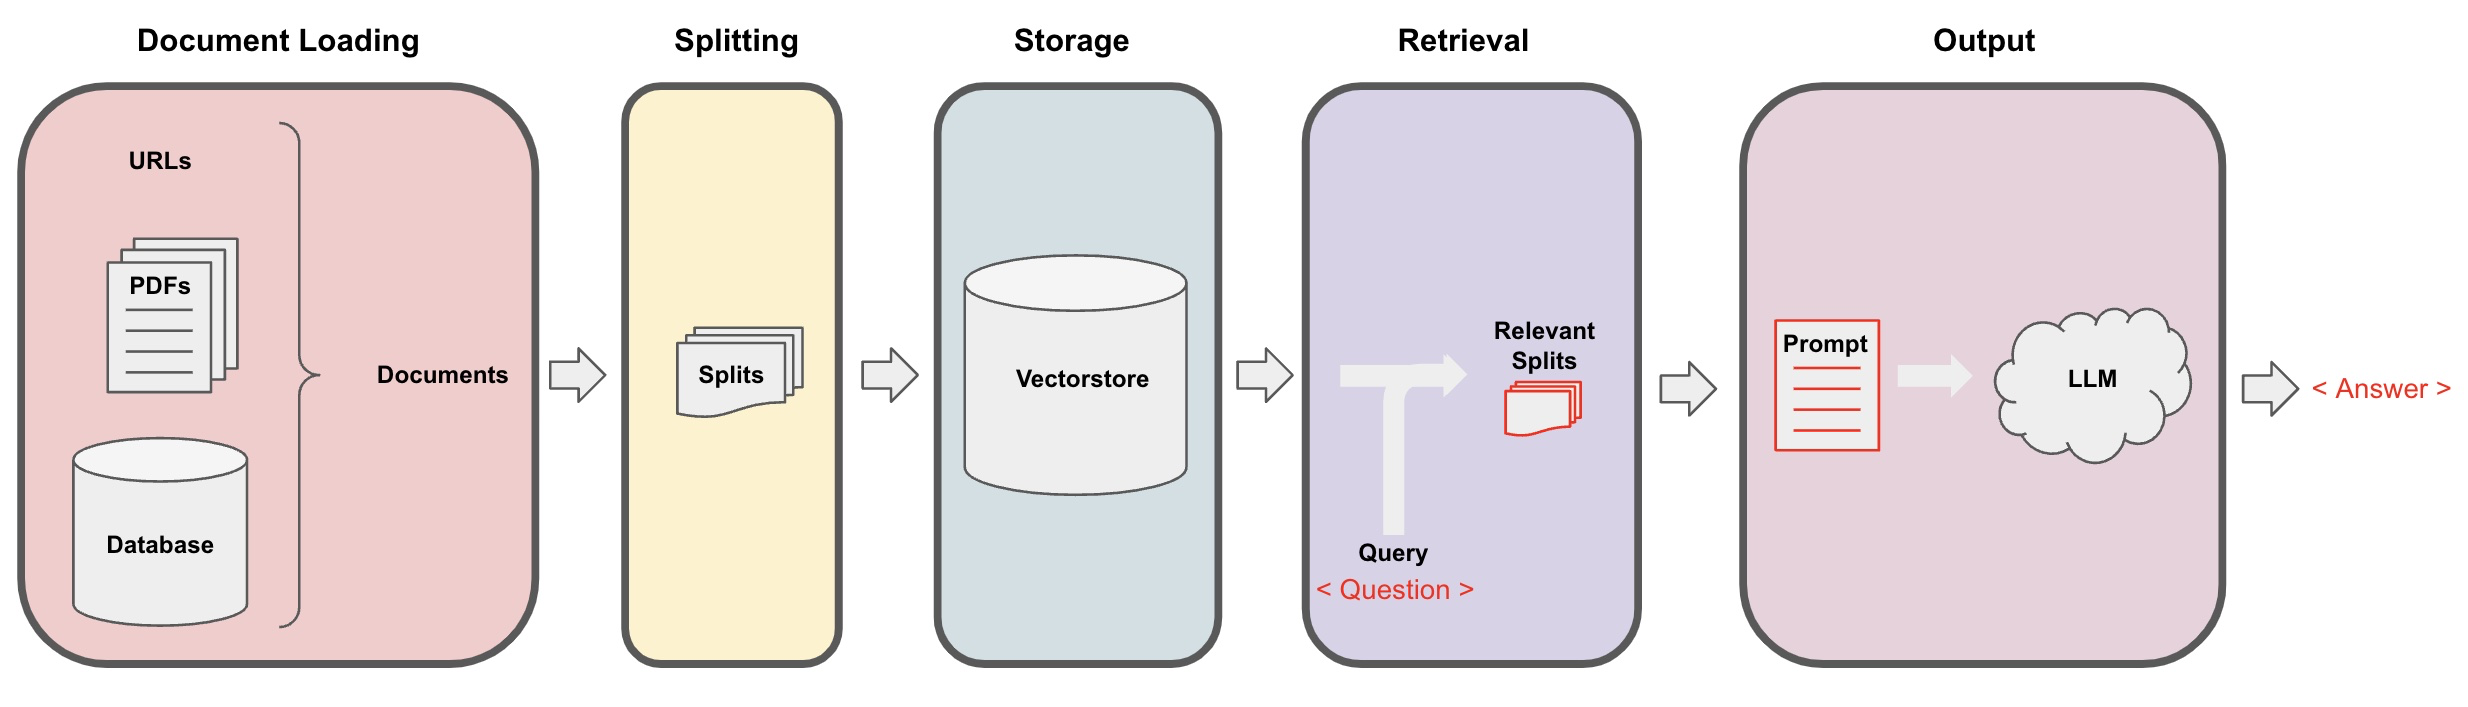

In [ ]:
pip install pypdf

As in this use case, we are trying to converse with our PDF file so we'll be using PyPDFLoader loader to load the PDF file.

In [ ]:
from langchain.document_loaders import PyPDFLoader

In [ ]:
loader = PyPDFLoader("/content/MachineLearning-Lecture01.pdf")
pages = loader.load()

After loading the document we now need to split the data into small chunks. Here we are intiating 2 params chunk size and chunk overlap, as the name suggest, chunk size defines how much should be the size of each chunk when we split the data from PDF file and chunk overlap is basically to maintain the contexts between two chunks.Typically, an overlap of 10-20% of the chunk size is a good starting point. Trade-offs: More overlap means better context preservation but can lead to redundancy and increased computational load. Find a balance based on your specific application needs.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

In [ ]:
chunk_size =1000
chunk_overlap = 150

In [ ]:
page=pages[0]

In [ ]:
len(pages)

There are number of Text splitters in Langchain. You can explore this based on use case https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/

Also, you can see I've manually defined separators,

1. \n\n is double line
2. \n is single line
3. " " is space
4. ?<=\. is for precedence for end of line.

By default we already have this in place, but just in case if you want to play around you can do it like this.

In [ ]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)

In [ ]:
splits = r_splitter.split_documents(pages)

In [ ]:
len(splits)

In [ ]:
pip install faiss-cpu

Till now, we have loaded the documents, splitted the documents into chunks. Now, we will be indexing the chunks to form embeddings and storing the embeddings into vector store. Here, I am using BERT model for text embeddings.

In [ ]:
from sentence_transformers import SentenceTransformer
#import faiss
import numpy as np
model = SentenceTransformer("sentence-transformers/bert-base-nli-mean-tokens")  # A BERT-based model

In [ ]:
sentence1 = "i like dogs and weather is good"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [ ]:
embedding1 = model.encode(sentence1)
embedding2 = model.encode(sentence2)
embedding3 = model.encode(sentence3)

In [ ]:
import numpy as np

In [ ]:
np.dot(embedding1, embedding3)

In [ ]:
from sentence_transformers import SentenceTransformer

# Load a BERT-based embedding model
model = SentenceTransformer("sentence-transformers/bert-base-nli-mean-tokens")



embedded_splits = []
for doc in splits:
    text = doc.page_content  # Extract the text content
    metadata = doc.metadata  # Extract the metadata

    # Generate embedding for the text
    embedding = model.encode(text)

    # Store the embedding and metadata
    embedded_splits.append({
        "embedding": embedding,
        "metadata": metadata
    })

In [ ]:
embedded_splits

After creating embeddings we need to store the embeddings in vector db for retrieval. We'll be using Chroma to store our embeddings into vector store.

In [ ]:
pip install chromadb

In [ ]:
from langchain.vectorstores import Chroma

In [ ]:
persist_directory = 'docs/chroma/ML'

In [ ]:
rm -rf ./docs/chroma

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# Load your BERT model for embedding
embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/bert-base-nli-mean-tokens")

# Persist directory for storing vector data
persist_directory = "docs/chroma/ML/"

# Use Chroma.from_documents to add documents to the vector store
vectordb = Chroma.from_documents(
    documents=splits,  # List of Document objects
    embedding=embedding_function,  # Pass the embedding function, not the precomputed embeddings
    persist_directory=persist_directory  # Directory for persistence
)

In [ ]:
print(vectordb._collection.count())

In [ ]:
question = "Is there any mention of MATLAB?"

# RETRIEVAL

Retrieval is one of the important step in this process. There are different retrieval methods by which we can retrieve the data from Vector store.
https://python.langchain.com/v0.1/docs/modules/data_connection/

Here, we will be using similarity search!

We give the query and it gives relevant splits from the vector store!. You can try different methods and check which best fits your case.

In [ ]:
docs = vectordb.similarity_search(question,k=5)

In [ ]:
len(docs)

In [ ]:
docs[3].page_content

Saving it for later use!

In [ ]:
vectordb.persist()

Model Llama 3.3 70B

In [ ]:
question = "What are major topics for this class?"
docs = vectordb.similarity_search(question,k=10)
len(docs)

#THE LAST DANCE

Till now, we have

Loaded Doc -> Split Data into Chunks -> Create Embeddings -> Store in Vector DB -> Retrieval

Now, we'll be using LLama 3.3 70B model and provide the model with prompt and it will answer the questions based on the document we provided.

In [ ]:
from langchain.chains import RetrievalQA

In [ ]:
from groq import Groq
from datetime import datetime

# Initialize Groq client
client = Groq(api_key="your_api_key_here")

# Today's date
today_date = datetime.now().strftime("%d %B %Y")

# Retrieved context
query = "Is there any mail ID to reach out"
retriever = vectordb.as_retriever(search_kwargs={"k": 10})
relevant_docs = retriever.get_relevant_documents(query)
context = " ".join([doc.page_content for doc in relevant_docs])

# Construct messages
messages = [
    {
        "role": "system",
        "content": f"Cutting Knowledge Date: December 2023\nToday Date: {today_date}\nYou are a helpful assistant. Use the provided context to answer questions accurately."
    },
    {
        "role": "user",
        "content": f"Context:\n{context}\n\nQuestion: {query}"
    }
]

# Call the LLaMA model
response = client.chat.completions.create(
    model="llama-3.3-70b-versatile",
    messages=messages,
    max_tokens=1024,
    temperature=0
)

model_response = response.choices[0].message.content
print(f"Answer: {model_response}")


We will be using Langchain's ConversationBufferMemory and ConversationalRetrievalChain to maintain chat history!

In [ ]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    memory_key="chat_history",
    return_messages=True
)

In [ ]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate
from langchain_groq import ChatGroq
import os

# Set Groq API key
os.environ["GROQ_API_KEY"] = "your_api_key_here"

# Initialize the ChatGroq LLM
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.7,
    max_tokens=2000
)

# Define the retriever (Chroma vectordb is already set up)
retriever = vectordb.as_retriever(search_kwargs={"k": 10})

# Initialize conversational memory
memory = ConversationBufferMemory(
    memory_key="chat_history",  # Key to store conversation history
    return_messages=True       # Ensures messages are returned with responses
)

# Define a custom prompt (optional)
prompt_template = PromptTemplate(
    template="""
You are a helpful assistant. Use the provided context and chat history to answer questions accurately.

Chat History:
{chat_history}

Context:
{context}

Question:
{question}

Answer:
""",
    input_variables=["chat_history", "context", "question"]
)

# Create the conversational retrieval chain
qa = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory
)

# Example interaction
query_1 = "Is there any mention about MATLAB?"
response_1 = qa({"question": query_1})
print(f"Q: {query_1}\nA: {response_1['answer']}")

In [ ]:
query_2 = "What were the projects that students had done last year?"
response_2 = qa({"question": query_2})
print(f"Q: {query_2}\nA: {response_2['answer']}")

In [ ]:
query_2 = "How do we classify is the tumor is dangerous or benign?"
response_2 = qa({"question": query_2})
print(f"Q: {query_2}\nA: {response_2['answer']}")

In [ ]:
query_2 = "Can you summarize in short what all things are mentioned in the document?"
response_2 = qa({"question": query_2})
print(f"Q: {query_2}\nA: {response_2['answer']}")